In [23]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow.random import set_seed 
import tensorflow as tf

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
import csv

## 데이터 불러오기

In [46]:
df_train = pd.read_csv("D:/Data/신호데이터/ECG/mitbih_train.csv/archive/mitbih_train.csv", header=None)
df_test = pd.read_csv("D:/Data/신호데이터/ECG/mitbih_train.csv/archive/mitbih_test.csv", header=None)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
y_df = df_train.iloc[:, -1]
y_df = y_df.astype('int')
y_df.head()

0    0
1    0
2    0
3    0
4    0
Name: 187, dtype: int32

In [32]:
df = pd.read_csv("D:/Data/ECGDB/1/1.csv", header=None)

In [48]:
df_train[187]=df_train[187].astype(int)
equilibre=df_train[187].value_counts()
print(equilibre)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


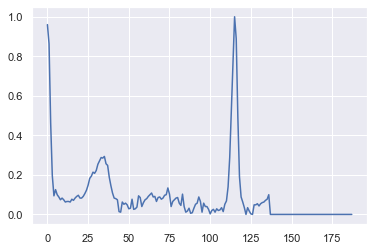

In [52]:
plt.plot(df_train.loc[1,:500002])

In [53]:
def plot_equilibre(equilibre):
    plt.figure(figsize=(10,10))
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

In [54]:
print(df_train[187].value_counts())

# plot_equilibre(df_train[187].value_counts())

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


In [55]:
X_train = df_train.values[:, :-1]
y_train = df_train.values[:, -1].astype(int)

X_test  = df_test.values[:, :-1]
y_test  = df_test.values[:, -1].astype(int)

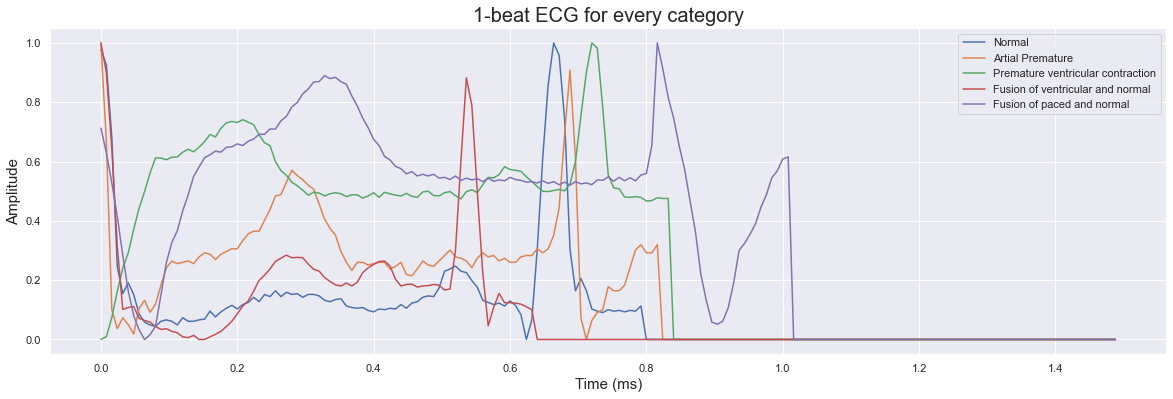

In [56]:
C0 = np.argwhere(y_train == 0).flatten()
C1 = np.argwhere(y_train == 1).flatten()
C2 = np.argwhere(y_train == 2).flatten()
C3 = np.argwhere(y_train == 3).flatten()
C4 = np.argwhere(y_train == 4).flatten()

x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,6))
plt.plot(x, X_train[C0, :][0], label="Normal")
plt.plot(x, X_train[C1, :][0], label="Artial Premature")
plt.plot(x, X_train[C2, :][0], label="Premature ventricular contraction")
plt.plot(x, X_train[C3, :][0], label="Fusion of ventricular and normal")
plt.plot(x, X_train[C4, :][0], label="Fusion of paced and normal")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

In [57]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

print(X_train.shape)
print(X_test.shape)

(87554, 187, 1)
(21892, 187, 1)


In [58]:
from tensorflow.keras import utils
y_train = utils.to_categorical(y_train)
y_test  = utils.to_categorical(y_test)

print(y_train.shape)
print(y_test.shape)

(87554, 5)
(21892, 5)


In [59]:
n_obs, feature, depth = X_train.shape
num_classes= 5

## 모델 생성

In [60]:
from tensorflow.keras import models, layers, optimizers, callbacks

inputs = layers.Input(shape=(feature,depth))
C   = layers.Conv1D(filters=32, kernel_size=5, strides=1)(inputs)

C11 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = layers.Activation("relu")(C11)
C12 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = layers.Add()([C12, C])
A12 = layers.Activation("relu")(S11)
M11 = layers.MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = layers.Activation("relu")(C21)
C22 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = layers.Add()([C22, M11])
A22 = layers.Activation("relu")(S11)
M21 = layers.MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = layers.Activation("relu")(C31)
C32 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = layers.Add()([C32, M21])
A32 = layers.Activation("relu")(S31)
M31 = layers.MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = layers.Activation("relu")(C41)
C42 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = layers.Add()([C42, M31])
A42 = layers.Activation("relu")(S41)
M41 = layers.MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = layers.Activation("relu")(C51)
C52 = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = layers.Add()([C52, M41])
A52 = layers.Activation("relu")(S51)
M51 = layers.MaxPooling1D(pool_size=5, strides=2)(A52)

F1  = layers.Flatten()(M51)

D1  = layers.Dense(32)(F1)
A6  = layers.Activation("relu")(D1)
D2  = layers.Dense(32)(A6)

outputs = layers.Dense(num_classes, activation="softmax")(D2)

model = models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 183, 32)      192         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 183, 32)      5152        ['conv1d[0][0]']                 
                                                                                                  
 activation (Activation)        (None, 183, 32)      0           ['conv1d_1[0][0]']               
                                                                                              

In [61]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
batch_size = 50
num_epochs = 20

In [63]:
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/20
1752/1752 [==============================] - 35s 8ms/step - loss: 0.1672 - accuracy: 0.9539 - val_loss: 0.1004 - val_accuracy: 0.9745
Epoch 2/20
1752/1752 [==============================] - 14s 8ms/step - loss: 0.0836 - accuracy: 0.9766 - val_loss: 0.0959 - val_accuracy: 0.9725
Epoch 3/20
1752/1752 [==============================] - 14s 8ms/step - loss: 0.0683 - accuracy: 0.9806 - val_loss: 0.0692 - val_accuracy: 0.9812
Epoch 4/20
1752/1752 [==============================] - 14s 8ms/step - loss: 0.0594 - accuracy: 0.9826 - val_loss: 0.0699 - val_accuracy: 0.9820
Epoch 5/20
1752/1752 [==============================] - 14s 8ms/step - loss: 0.0533 - accuracy: 0.9844 - val_loss: 0.0620 - val_accuracy: 0.9826
Epoch 6/20
1752/1752 [==============================] - 14s 8ms/step - loss: 0.0499 - accuracy: 0.9851 - val_loss: 0.0595 - val_accuracy: 0.9838
Epoch 7/20
1752/1752 [==============================] - 13s 8ms/step - loss: 0.0457 - accuracy: 0.9861 - val_loss: 0.0596 - val_ac

In [68]:
models.save_model(model, 'ecg_arrhythmia_with_ECG.hdf1')

INFO:tensorflow:Assets written to: ecg_arrhythmia_with_ECG.hdf1\assets


C:\Users\user\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\Users\user\anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [65]:
from sklearn.metrics import classification_report, confusion_matrix

labels = ["Normal",
          "Artial Premature",
          "Premature ventricular contraction",
          "Fusion of ventricular and normal",
          "Fusion of paced and normal"]

In [66]:
# Test Model
predY = model.predict(X_test)
y_pred = np.argmax(predY,axis=1)
y_actual = np.argmax(y_test,axis=1)
cm = confusion_matrix(y_actual, y_pred)
print(cm)

[[18062    29    20     5     2]
 [  104   439    10     3     0]
 [   33     9  1382    23     1]
 [   16     0    11   135     0]
 [   23     0     2     0  1583]]


In [67]:
print(classification_report(y_actual, y_pred, target_names=labels))

                                   precision    recall  f1-score   support

                           Normal       0.99      1.00      0.99     18118
                 Artial Premature       0.92      0.79      0.85       556
Premature ventricular contraction       0.97      0.95      0.96      1448
 Fusion of ventricular and normal       0.81      0.83      0.82       162
       Fusion of paced and normal       1.00      0.98      0.99      1608

                         accuracy                           0.99     21892
                        macro avg       0.94      0.91      0.92     21892
                     weighted avg       0.99      0.99      0.99     21892

